In [95]:
include("../code/julia/ha-trade.jl")
include("../code/julia/ha-trade-welfare.jl")

using MINPACK
using Plots
using CSV
using DataFrames

In [96]:
γ = 1.5 # curvatuve on CRRA utility function
σϵ = 0.25 # logit dispersion parameter
Ncntry = 2 # number of countries

# this setups up parameters on the household side
hh_prm = household_params(Ncntry = Ncntry, Na = 100, β = 0.92, γ = γ, ϕ = 0.5, amax = 8.0, σϵ = σϵ, ψslope = 0.2);

#ψslope controls how residual demand varies with income state...

In [97]:
# here are some simpe country parametrers
TFP = [1.0; 1.0]

τ = [0.0; 0.0]

L = [1.0; 1.0]

d_ij = 1.745

d = [1.0 d_ij; d_ij 1.0]

# this sets up the country specific paramters
cntry_prm = country_params(Ncntry = Ncntry, L = L, d = d, TFP = TFP);

In [98]:
f(x) = world_equillibrium_FG(exp.(x), hh_prm, cntry_prm)
# this world... function is used to construct zero conditions for
# the finacial globalization case

function f!(fvec, x)

    fvec .= f(x)

end


xguess = [1.0; 1.02]

n = length(xguess)
diag_adjust = n - 1

sol = fsolve(f!, log.(xguess), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-10,
       )

# This solver works very well in general. Spencer Lyon converted old-school minpack
# routines in C into julia

print(sol)

wage = [exp.(sol.x[1]); 1.0]
R = exp.(sol.x[2])

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.992083e-01     0.000000e+00         2.656000
     2     2.253156e-02     4.054422e-05         0.346000
     3     3.170333e-03     1.074674e-06         0.089000
     4     4.916331e-05     2.946856e-08         0.096000
     5     1.685977e-07     7.182151e-12         0.101000
     6     1.002796e-10     8.588696e-17         0.111000
     7     4.424239e-13     2.833389e-23         0.139000
     8     3.289036e-15     5.500317e-28         0.169000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.0, 0.01980262729617973]
 * Zero: [-2.2768317339848573e-9, 0.01258038097184609]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 3.731000 seconds
 * Function Calls: 8
 * Jacobian Calls (df/dx): 1

1.012659846851913

In [99]:
Rsol = [R; R]

Y, tradeflows, A_demand, Gbudget, tradeshare, hh, dist = world_equillibrium(Rsol, wage, τ, hh_prm, cntry_prm, tol_vfi = 1e-10);


In [100]:
R

1.012659846851913

In [101]:
tradeshare

2×2 Matrix{Float64}:
 0.912448   0.0875522
 0.0875522  0.912448

In [102]:
hh[1].πprob[:,:,2]
# guys in country one, a X z, probability of buying from 2

100×10 Matrix{Float64}:
 0.0203927  0.0360656  0.0380981  …  0.069461   0.0833217  0.0675049
 0.0374807  0.0397536  0.0524594     0.0704901  0.0860155  0.0678605
 0.0517403  0.0489637  0.0661095     0.071409   0.0879135  0.06821
 0.057837   0.0523315  0.0715266     0.0722387  0.089045   0.0685533
 0.0693525  0.0560704  0.0789035     0.0730149  0.0898944  0.0688905
 0.0744127  0.0612837  0.08379    …  0.0737619  0.0906548  0.0692287
 0.0797019  0.0647962  0.087817      0.0745066  0.0913656  0.0695538
 0.0862534  0.0682007  0.0925053     0.0752162  0.0920282  0.0698665
 0.0913775  0.0715594  0.096533      0.0758752  0.0926106  0.0701749
 0.0959336  0.0749256  0.0996836     0.0765248  0.0931592  0.0704782
 0.100463   0.0778429  0.10262    …  0.0771596  0.0936835  0.0707768
 0.105026   0.0807764  0.105696      0.077774   0.094189   0.0710721
 0.108972   0.0836368  0.108843      0.0783727  0.0946961  0.0713645
 ⋮                                ⋱                        
 0.25642    0.194793 

In [103]:
cntry = 1 # this is the country I'll look at

# the next several functions are what is done to make
# the country specific, household parameter vector.

p = make_p(wage, TFP, d[cntry, :], cntry_prm.tariff[cntry, :] )
# prices from the perspective of those in that country

ψ = make_ψ(cntry, hh_prm)
# this is the quality matrix

agrid = make_agrid(hh_prm, TFP[cntry])
# this creates teh asset grid so it's alwasy a fraction of home labor income

foo_hh_prm = household_params(hh_prm, agrid = agrid, 
                TFP = TFP[cntry], L = L[cntry], σϵ = σϵ*(TFP[cntry]^(1.0 - γ)), ψ = ψ)


hh = solve_household_problem(R, wage[cntry], p, τ[cntry], foo_hh_prm, tol = 1e-10);
# solve hh problem at those prices

dist = make_stationary_distribution(hh, foo_hh_prm);
# find stationary distribution

In [104]:
θ = make_θ(cntry, R, wage[cntry], p, τ[cntry], foo_hh_prm; points = 3, order = 1)
# makes the micro elasticities for country, cntry, 

ω = make_ω(hh, dist, L[cntry], p, foo_hh_prm)
# makes the expenditure weights

agθ = aggregate_θ(θ, ω, cntry, foo_hh_prm)
# construct the aggregate elasticity. The interesting element here is 
# agθ[cntry]

2-element Vector{Float64}:
  1.0
 -4.423364745419634

In [105]:
θ.θπ[:,:,2]

100×10 Matrix{Float64}:
 -9.84039  -7.49951  -7.67199  -6.03182  …  -3.95506  -3.68012  -3.34198
 -8.44995  -7.31585  -6.90444  -5.89775     -3.90715  -3.57544  -3.32812
 -7.35159  -6.69562  -6.27568  -5.63335     -3.89812  -3.48079  -3.3144
 -7.15436  -6.64145  -5.89493  -5.60147     -3.86516  -3.39494  -3.30102
 -6.54368  -6.45686  -5.7512   -5.43533     -3.8294   -3.38216  -3.28773
 -6.48334  -6.15705  -5.48723  -5.26299  …  -3.7988   -3.35089  -3.27433
 -6.28645  -6.12345  -5.36659  -5.19133     -3.77237  -3.32526  -3.27263
 -6.00541  -5.97052  -5.27881  -5.16935     -3.76786  -3.30089  -3.26095
 -5.94673  -5.83645  -5.10709  -5.07031     -3.74217  -3.29771  -3.25001
 -5.7911   -5.79982  -5.03198  -4.96556     -3.71892  -3.2799   -3.23914
 -5.65145  -5.65864  -5.00536  -4.89874  …  -3.69517  -3.26262  -3.22862
 -5.5098   -5.54548  -4.90502  -4.88527     -3.67375  -3.24659  -3.21801
 -5.4754   -5.45071  -4.7997   -4.81898     -3.65285  -3.23211  -3.20738
  ⋮                         

In [106]:
fooX = make_Xsection(R, wage[cntry], p, hh, dist, cntry, foo_hh_prm; Nsims = 100000)

hhXsection([2.737242587905087, 2.737242587905087, 2.737242587905087, 2.737242587905087, 2.737242587905087, 0.7003921591779129, 0.7003921591779129, 1.1060902641675332, 1.1060902641675332, 1.1060902641675332  …  1.1017996623151916, 1.740010740526207, 1.740010740526207, 1.1017996623151916, 2.737242587905087, 2.737242587905087, 1.1017996623151916, 1.1017996623151916, 1.1017996623151916, 1.1017996623151916], [2.7626262626262625, 3.2777777777777777, 3.878787878787879, 4.308080808080808, 4.737373737373737, 5.166666666666667, 4.308080808080808, 3.5353535353535355, 3.191919191919192, 2.9343434343434343  …  1.904040404040404, 1.4747474747474747, 1.5606060606060606, 1.6464646464646464, 1.2171717171717171, 1.904040404040404, 2.505050505050505, 1.9898989898989898, 1.5606060606060606, 1.1313131313131313], [5.534843275925271, 6.056516530364135, 6.665135327209477, 7.099863039241864, 7.53459075127425, 5.932468034579464, 5.063012610514689, 4.686200833846014, 4.338418664220104, 4.077582037000672  …  3.02

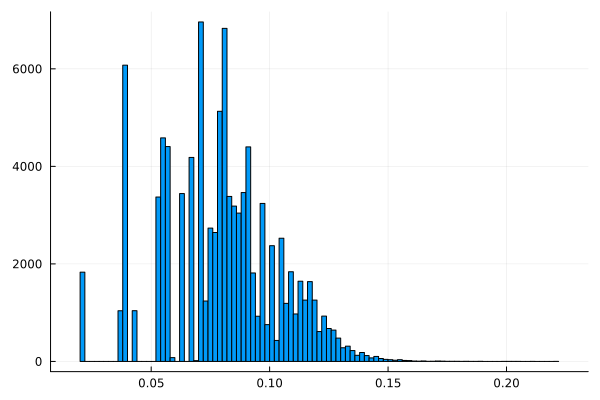

In [107]:
histogram((1.0 .-fooX.homeshare), label = false)

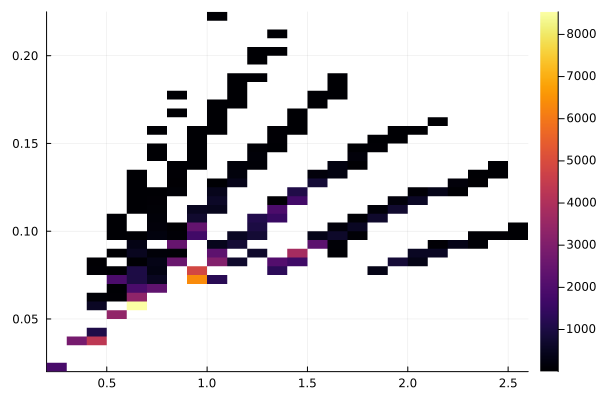

In [108]:
histogram2d(fooX.pc, (1.0 .-fooX.homeshare))

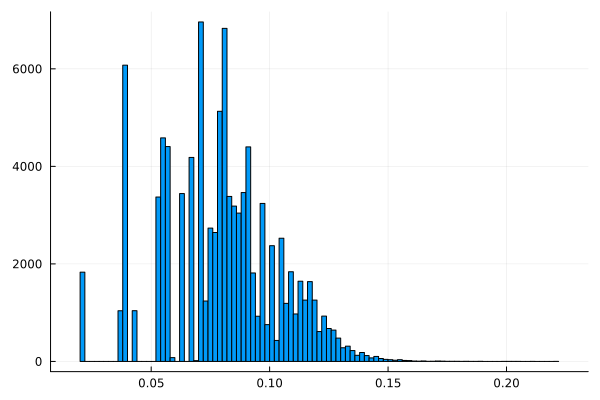

In [109]:
histogram((1.0 .-fooX.homeshare), label = false)

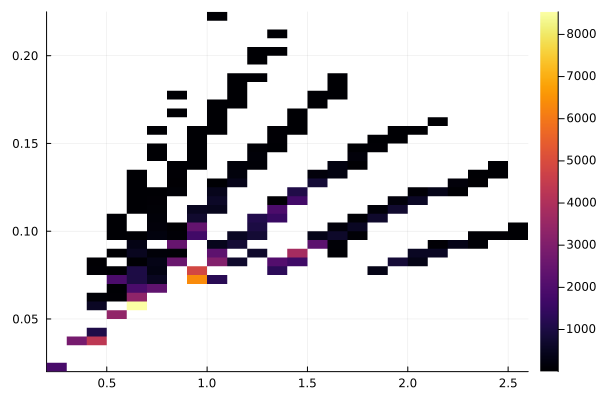

In [110]:
histogram2d(fooX.pc, (1.0 .-fooX.homeshare))

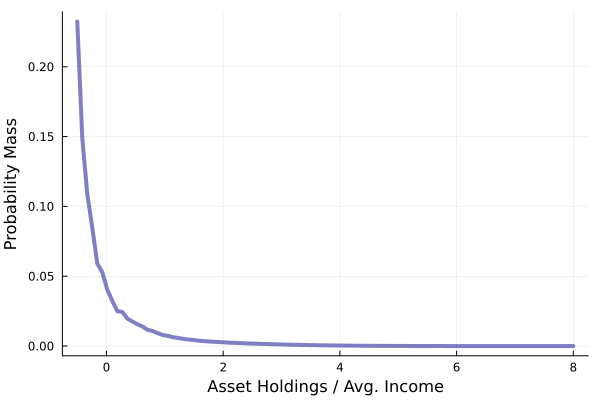

In [111]:
adist = get_distribution(dist.state_index, dist.λ);

plot(hh_prm.agrid , adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", 
    xlabel = "Asset Holdings / Avg. Income", label = false)

In [112]:
Δd = 0.10

d = [1.0 d_ij * (1 - Δd)  ; d_ij * (1 - Δd)  1.0]

# this sets up the country specific paramters
Δd_cntry_prm = country_params(Ncntry = Ncntry, L = L, d = d, TFP = TFP);

In [113]:
f(x) = world_equillibrium_FG(exp.(x), hh_prm, Δd_cntry_prm)

function f!(fvec, x)

    fvec .= f(x)

end


xguess = [1.0; 1.02]

n = length(xguess)
diag_adjust = n - 1

sol = fsolve(f!, log.(xguess), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-10,
       )

print(sol)

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     2.076628e-01     0.000000e+00         0.113000
     2     2.401431e-02     4.322653e-05         0.393000
     3     3.369768e-03     9.742138e-07         0.113000
     4     6.065843e-05     2.573251e-08         0.101000
     5     1.294972e-07     8.681806e-12         0.117000
     6     3.226280e-10     4.129300e-17         0.145000
     7     1.866389e-12     2.335057e-22         0.118000
     8     1.658396e-15     7.991134e-27         0.103000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.0, 0.01980262729617973]
 * Zero: [-1.5653828386609878e-9, 0.012281498076045965]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 1.204000 seconds
 * Function Calls: 8
 * Jacobian Calls (df/dx): 1

In [114]:
Δwage = [exp.(sol.x[1]); 1.0]
ΔR = exp.(sol.x[2])

ΔRsol = [ΔR; ΔR]


ΔY, Δtradeflows, ΔA_demand, ΔGbudget, Δtradeshare, Δhh, Δdist = world_equillibrium(ΔRsol, Δwage, τ, hh_prm, 
                                                Δd_cntry_prm, tol_vfi = 1e-10);

In [115]:
ΔR

1.0123572253708704

In [116]:
Δtradeshare

2×2 Matrix{Float64}:
 0.867717  0.132283
 0.132283  0.867717

In [117]:
cntry = 1

ψ = make_ψ(cntry, hh_prm)
# this is the quality matrix

agrid = make_agrid(hh_prm, TFP[cntry])
# this creates teh asset grid so it's alwasy a fraction of home labor income

foo_hh_prm = household_params(hh_prm, agrid = agrid, 
                TFP = TFP[cntry], L = L[cntry], σϵ = σϵ*(TFP[cntry]^(1.0 - γ)), ψ = ψ)


λeqv = lucas_eq_variation(hh, Δhh[cntry], dist.state_index, foo_hh_prm)

100×10 Matrix{Float64}:
 1.00884  1.00919  1.01028  1.01056  …  1.01233  1.01244  1.01285  1.01293
 1.00915  1.00934  1.01051  1.01077     1.0124   1.01249  1.01288  1.01296
 1.00946  1.00965  1.01074  1.01087     1.01247  1.01253  1.0129   1.01298
 1.00966  1.00985  1.01086  1.01098     1.01251  1.01258  1.01292  1.01301
 1.00997  1.01001  1.01108  1.01117     1.01256  1.01262  1.01295  1.01304
 1.01019  1.01024  1.01119  1.01128  …  1.01261  1.01267  1.01299  1.01307
 1.01037  1.01044  1.0113   1.01138     1.01266  1.01271  1.01302  1.0131
 1.01057  1.0106   1.01151  1.01148     1.01271  1.01275  1.01304  1.01312
 1.01081  1.01075  1.01162  1.01161     1.01275  1.0128   1.01307  1.01315
 1.01098  1.01091  1.01172  1.01173     1.0128   1.01284  1.0131   1.01318
 1.01114  1.0111   1.01184  1.01183  …  1.01285  1.01288  1.01313  1.0132
 1.01131  1.01125  1.01197  1.01193     1.0129   1.01292  1.01316  1.01323
 1.01149  1.01139  1.01209  1.01203     1.01294  1.01296  1.01319  1.01326
 ⋮ 

λeqv